<a href="https://colab.research.google.com/github/t4n15hq/luminari/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import tensorflow as tf
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model, optimizers
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging
from sklearn.utils.class_weight import compute_class_weight
import datetime
from google.colab import drive

# Mount Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
class Config:
    def __init__(self):
        self.base_path = '/content/drive/MyDrive/dataset/SkinDisease'
        self.processed_dir = os.path.join(self.base_path, 'processed_data')
        self.model_dir = os.path.join(self.base_path, 'models')
        self.image_size = (224, 224, 3)  # Increased image size
        self.batch_size = 8  # Reduced for gradient stability
        self.epochs = 150  # Increased training time
        self.initial_learning_rate = 5e-5  # Adjusted learning rate
        self.validation_split = 0.2
        self.learning_rate = 0.0001  # Added learning rate
        self.use_mixed_precision = True  # Enable mixed precision training

        # Create directories
        os.makedirs(self.model_dir, exist_ok=True)

        # Enable mixed precision
        if self.use_mixed_precision:
            policy = tf.keras.mixed_precision.Policy('mixed_float16')
            tf.keras.mixed_precision.set_global_policy(policy)

In [29]:
class DataLoader:
    def __init__(self, config):
        self.config = config

    def normalize_image(self, image):
        """Normalize image with contrast enhancement"""
        mean = np.mean(image)
        std = np.std(image)
        normalized = (image - mean) / (std + 1e-7)
        return np.clip(normalized, -3, 3)  # Clip outliers

    def load_data(self, data_type='train_balanced'):
        data_dir = os.path.join(self.config.processed_dir, data_type)
        print(f"Loading data from: {data_dir}")

        if not os.path.exists(data_dir):
            raise Exception(f"Data directory not found: {data_dir}")

        images = []
        labels = []
        class_names = []

        # Changed from .npy to .npz
        class_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.npz')])
        print(f"Found {len(class_files)} classes")

        # Load and preprocess data
        for i, class_file in enumerate(tqdm(class_files, desc="Loading classes")):
            class_name = class_file.replace('.npz', '')  # Changed from .npy to .npz
            class_names.append(class_name)

            # Load from npz file using 'data' key
            loaded_data = np.load(os.path.join(data_dir, class_file))
            class_images = loaded_data['data']

            # Apply normalization to each image
            class_images = np.array([self.normalize_image(img) for img in class_images])

            images.append(class_images)
            labels.extend([i] * len(class_images))

        images = np.concatenate(images)
        labels = np.array(labels)

        # Calculate class weights
        class_weights = compute_class_weight('balanced',
                                           classes=np.unique(labels),
                                           y=labels)
        class_weight_dict = dict(enumerate(class_weights))

        print(f"Loaded {len(images)} images with shape {images.shape}")
        return images, labels, len(class_files), class_weight_dict, class_names

    def analyze_class_distribution(self):
        """Analyze and visualize class distribution"""
        data_dir = os.path.join(self.config.processed_dir, 'train_balanced')
        distribution = {}

        # Changed from .npy to .npz
        for class_file in os.listdir(data_dir):
            if class_file.endswith('.npz'):  # Changed extension
                class_name = class_file.replace('.npz', '')  # Changed extension
                loaded_data = np.load(os.path.join(data_dir, class_file))
                class_data = loaded_data['data']  # Access using 'data' key
                distribution[class_name] = len(class_data)

        # Plot distribution
        plt.figure(figsize=(15, 5))
        plt.bar(distribution.keys(), distribution.values())
        plt.xticks(rotation=45, ha='right')
        plt.title('Class Distribution')
        plt.ylabel('Number of Images')
        plt.tight_layout()
        plt.show()

        return distribution

In [30]:
def mixup(x, y, alpha=0.2):
    """Performs MixUp augmentation"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = tf.shape(x)[0]
    index = tf.random.shuffle(tf.range(batch_size))

    mixed_x = lam * x + (1 - lam) * tf.gather(x, index)
    mixed_y = lam * y + (1 - lam) * tf.gather(y, index)
    return mixed_x, mixed_y

In [31]:
class ModelBuilder:
    def __init__(self, config, num_classes):
        self.config = config
        self.num_classes = num_classes

    def build_model(self):
        # Using EfficientNetB4
        base_model = tf.keras.applications.EfficientNetB4(
            weights='imagenet',
            include_top=False,
            input_shape=(224, 224, 3)
        )

        base_model.trainable = False

        inputs = tf.keras.Input(shape=(224, 224, 3))
        x = tf.keras.applications.efficientnet.preprocess_input(inputs)
        x = base_model(x, training=False)
        x = layers.GlobalAveragePooling2D()(x)  # Output shape: (None, 1792)

        # Store initial features for residual connection with matching shape
        initial_features = layers.Dense(2048)(x)  # Match the shape of next dense layer

        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)

        # First dense block
        x = layers.Dense(2048,
                        activation='relu',
                        kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)

        # Add residual connection (now shapes match: both 2048)
        x = layers.Add()([x, initial_features])
        x = layers.Activation('relu')(x)

        # Second dense block
        x = layers.Dense(1024, activation='relu',
                        kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.4)(x)

        outputs = layers.Dense(self.num_classes, activation='softmax')(x)

        model = Model(inputs, outputs)

        model.compile(
            optimizer=optimizers.Adam(learning_rate=self.config.learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    def unfreeze_and_recompile(self, model, num_layers_to_unfreeze=15):
        base_model = model.get_layer('efficientnetb4')  # Changed to efficientnetb4
        base_model.trainable = True

        # Freeze earlier layers
        for layer in base_model.layers[:-num_layers_to_unfreeze]:
            layer.trainable = False

        # Lower learning rate for fine-tuning
        model.compile(
            optimizer=optimizers.Adam(learning_rate=5e-6),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

In [34]:
class Trainer:
    def __init__(self, config):
        self.config = config

    def train(self, model, train_data, train_labels, val_data, val_labels, class_weights):
        # Enhanced data augmentation
        train_datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=False,
            brightness_range=[0.7, 1.3],
            zoom_range=0.2,
            shear_range=0.15,
            channel_shift_range=20.0,
            fill_mode='nearest'
        )

        # Setup TensorBoard logging
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(
            log_dir=log_dir, histogram_freq=1
        )

        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                filepath=os.path.join(self.config.model_dir, 'best_model.keras'),
                save_best_only=True,
                monitor='val_accuracy',
                mode='max'
            ),
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=15,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=7,
                min_lr=1e-7,
                verbose=1
            ),
            tensorboard_callback,
            tf.keras.callbacks.CSVLogger('training_log.csv')
        ]

        history = model.fit(
            train_datagen.flow(
                train_data, train_labels,
                batch_size=self.config.batch_size
            ),
            validation_data=(val_data, val_labels),
            epochs=self.config.epochs,
            callbacks=callbacks,
            class_weight=class_weights
        )

        return history

    def plot_training_history(self, history):
        plt.figure(figsize=(15, 5))

        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Train', 'Validation'])

        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Train', 'Validation'])

        plt.tight_layout()
        plt.show()

Starting improved training pipeline...


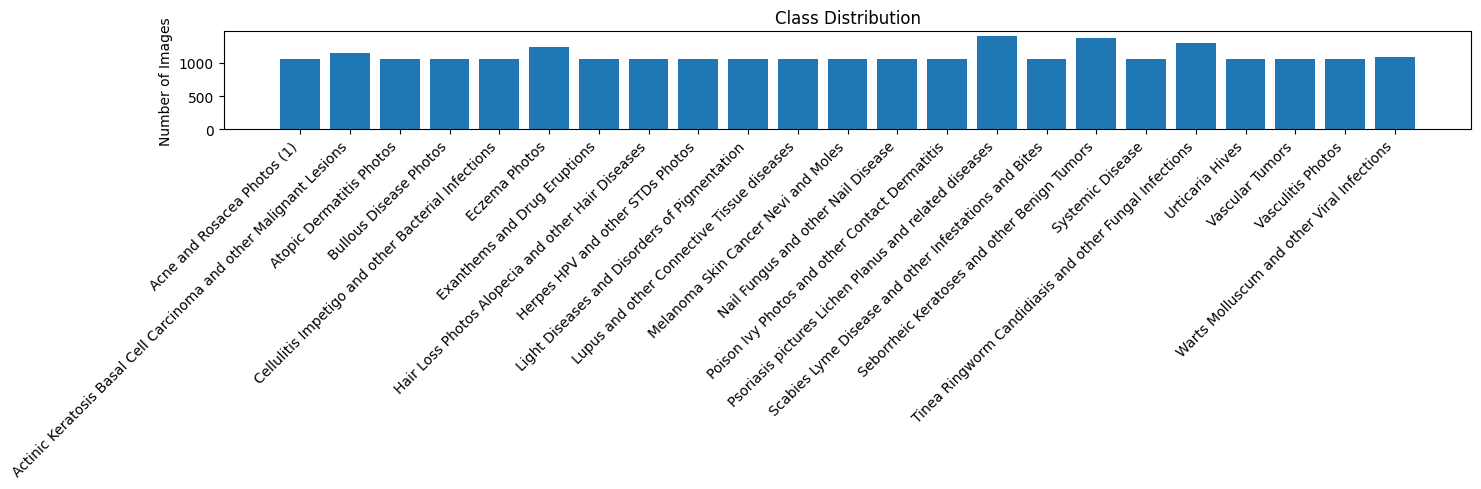

Loading data from: /content/drive/MyDrive/dataset/SkinDisease/processed_data/train_balanced
Found 23 classes


Loading classes:   0%|          | 0/23 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
Loading classes: 100%|██████████| 23/23 [04:53<00:00, 12.76s/it]


Loaded 25617 images with shape (25617, 224, 224, 3)
Loading data from: /content/drive/MyDrive/dataset/SkinDisease/processed_data/test
Found 23 classes


Loading classes:   0%|          | 0/23 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
Loading classes:  78%|███████▊  | 18/23 [00:35<00:11,  2.29s/it]/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
Loading classes: 100%|██████████| 23/23 [00:45<00:00,  2.00s/it]


Loaded 4002 images with shape (4002, 224, 224, 3)

Data shapes:
Training: (20493, 224, 224, 3)
Validation: (5124, 224, 224, 3)
Test: (4002, 224, 224, 3)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb4            │ (None, 7, 7, 1792)     │     17,673,823 │ input_layer_3[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1792)           │              0 │ efficientnetb4[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 1792)           │          7,168 │ global_average_poolin… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 1792)           │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 2048)           │      3,672,064 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 2048)           │          8,192 │ dense_5[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 2048)           │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 2048)           │      3,672,064 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 2048)           │              0 │ dropout_4[0][0],       │
│                           │                        │                │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 2048)           │              0 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1024)           │      2,098,176 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 1024)           │          4,096 │ dense_6[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 1024)           │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 23)             │         23,575 │ dropout_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 27,159,158 (103.60 MB)

 Trainable params: 9,475,607 (36.15 MB)

 Non-trainable params: 17,683,551 (67.46 MB)


Phase 1: Training with frozen backbone...
Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2561/2562 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.0468 - loss: 33.9233

In [ ]:
def main():
    try:
        print("Starting improved training pipeline...")

        # Initialize configuration
        config = Config()

        # Load and analyze data
        data_loader = DataLoader(config)
        data_loader.analyze_class_distribution()  # Visualize class distribution

        # Load data with class weights
        train_images, train_labels, num_classes, class_weights, class_names = data_loader.load_data('train_balanced')
        test_images, test_labels, _, _, _ = data_loader.load_data('test')

        # Split data
        X_train, X_val, y_train, y_val = train_test_split(
            train_images, train_labels,
            test_size=config.validation_split,
            random_state=42,
            stratify=train_labels
        )

        print(f"\nData shapes:")
        print(f"Training: {X_train.shape}")
        print(f"Validation: {X_val.shape}")
        print(f"Test: {test_images.shape}")

        # Build and train model
        model_builder = ModelBuilder(config, num_classes)
        model = model_builder.build_model()
        model.summary()

        trainer = Trainer(config)

        # Phase 1: Training with frozen backbone
        print("\nPhase 1: Training with frozen backbone...")
        history1 = trainer.train(model, X_train, y_train, X_val, y_val, class_weights)
        trainer.plot_training_history(history1)

        # Phase 2: Fine-tuning
        print("\nPhase 2: Fine-tuning...")
        model = model_builder.unfreeze_and_recompile(model)
        history2 = trainer.train(model, X_train, y_train, X_val, y_val, class_weights)
        trainer.plot_training_history(history2)

        # Evaluate on test set
        test_loss, test_accuracy = model.evaluate(test_images, test_labels)
        print(f"\nFinal Test accuracy: {test_accuracy:.4f}")
        print(f"Final Test loss: {test_loss:.4f}")

        # Save final model
        model.save(os.path.join(config.model_dir, 'final_model.h5'))

        # Save class names
        with open(os.path.join(config.model_dir, 'class_names.txt'), 'w') as f:
            for class_name in class_names:
                f.write(f"{class_name}\n")

        print("\nTraining completed successfully!")

    except Exception as e:
        print(f"\nError in training pipeline: {str(e)}")
        import traceback
        traceback.print_exc()
        raise

if __name__ == "__main__":
    main()